<a href="https://colab.research.google.com/github/tattwei/WGAN-GP/blob/master/WGAN_GP_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
import time
from IPython import display

tf.enable_eager_execution()

In [0]:


def RCgen():

    dim = np.array([100,220])  # dim[1] always larger, x dimension
    bmu = [np.random.normal(0.5,0.5),np.random.normal(0.5,0.5),np.random.normal(0.5,0.5)]
    bsigma = [0.1,0.1,0.1]

    pmu = 0.7
    psigma = 0.2

    lmu = 0.95
    lsigma = 0.05

    #scale
    sx = 1  # width
    sy =1  #height

    #pads and component will have its own translation and rotation angles.

    # Body dimensions
    height = int(0.4 * dim[0] + np.random.normal(0,0.1*dim[0])) # variations in scale
    aspratio = np.random.uniform(1.1,1.5)
    width = int(aspratio* height)   

    #rotation angle
    btheta = np.pi/180 * np.random.normal(0,4)
    ptheta = np.pi/180* np.random.normal(0,4)

    # translating the equations
    bmx=dim[1]/2 +np.random.normal(0,width*0.02)
    bmy=dim[0]/2 +np.random.normal(0,width*0.02)

    pmx=dim[1]/2 + np.random.normal(0,width*0.02)
    pmy=dim[0]/2 + np.random.normal(0,width*0.02)

    # Leads dimension
    lwidth = height/2 + np.random.normal(0,height*0.05)

    # Pads Dimension (reference to leads) - make it square
    edge = height*sy*1.2#np.random.uniform(width, width*(1.2))
    distance = (width+edge)/2; # from lead reference
    spacing = width  # between 2 pads

    # Body rotation & scale equations
    s_eq=np.array([-np.tan(btheta),1,(sy*height/2)/np.cos(btheta)])
    n_eq=np.array([-np.tan(btheta),1,(-sy*height/2)/np.cos(btheta)])
    w_eq=np.array([1,np.tan(btheta),(sx*width/2)/np.cos(btheta)])
    e_eq=np.array([1,np.tan(btheta),(-sx*width/2)/np.cos(btheta)])

    # Translate the body
    s_eq[2] = s_eq[2] -bmy + np.tan(btheta)*bmx
    n_eq[2] = n_eq[2] -bmy + np.tan(btheta)*bmx
    w_eq[2] = w_eq[2] -bmx - np.tan(btheta)*bmy
    e_eq[2] = e_eq[2] -bmx - np.tan(btheta)*bmy

    # Leads rotation & scale equations + translate
    w_eq_lead1= np.array([1,np.tan(btheta),(sx*(width+lwidth)/2)/np.cos(btheta)])
    w_eq_lead1[2] = w_eq_lead1[2] -bmx - np.tan(btheta)*bmy
    e_eq_lead1= w_eq
    w_eq_lead2= e_eq
    e_eq_lead2=np.array([1,np.tan(btheta),(-sx*(width+lwidth)/2)/np.cos(btheta)])
    e_eq_lead2[2] = e_eq_lead2[2] -bmx - np.tan(btheta)*bmy

    # Pads rotation & scale equations
    s_eq_pad1=np.array([-np.tan(ptheta),1,(sy*edge/2)/np.cos(ptheta)])
    n_eq_pad1=np.array([-np.tan(ptheta),1,(-sy*edge/2)/np.cos(ptheta)])
    w_eq_pad1=np.array([1,np.tan(ptheta),(sx*(spacing+2*edge)/2)/np.cos(ptheta)])
    e_eq_pad1=np.array([1,np.tan(ptheta),(sx*(spacing)/2)/np.cos(ptheta)])

    s_eq_pad2=np.array([-np.tan(ptheta),1,(sy*edge/2)/np.cos(ptheta)])
    n_eq_pad2=np.array([-np.tan(ptheta),1,(-sy*edge/2)/np.cos(ptheta)])
    w_eq_pad2=np.array([1,np.tan(ptheta),(-sx*spacing/2)/np.cos(ptheta)])
    e_eq_pad2=np.array([1,np.tan(ptheta),(-sx*(spacing+2*edge)/2)/np.cos(ptheta)])

    # Translate the pads
    s_eq_pad1[2] = s_eq_pad1[2] -pmy + np.tan(ptheta)*pmx
    n_eq_pad1[2] = n_eq_pad1[2] -pmy + np.tan(ptheta)*pmx
    w_eq_pad1[2] = w_eq_pad1[2] -pmx - np.tan(ptheta)*pmy
    e_eq_pad1[2] = e_eq_pad1[2] -pmx - np.tan(ptheta)*pmy

    s_eq_pad2[2] = s_eq_pad2[2] -pmy + np.tan(ptheta)*pmx
    n_eq_pad2[2] = n_eq_pad2[2] -pmy + np.tan(ptheta)*pmx
    w_eq_pad2[2] = w_eq_pad2[2] -pmx - np.tan(ptheta)*pmy
    e_eq_pad2[2] = e_eq_pad2[2] -pmx - np.tan(ptheta)*pmy

    # Rendering the image
    body = np.zeros([dim[0],dim[1],3])
    leads = np.zeros([dim[0],dim[1],3])
    pads = np.zeros([dim[0],dim[1],3])

    # Body, pads and leads intensity (texture) model
    for iter in [0,1,2]:
        body[:,:,iter] = np.random.normal(bmu[iter], bsigma[iter], dim)

    leads[:,:,0] = np.random.normal(lmu, lsigma, dim)
    leads[:,:,1] =leads[:,:,0]
    leads[:,:,2] =leads[:,:,0]
    pads[:,:,0] = np.random.normal(pmu, psigma, dim)
    pads[:,:,1] =pads[:,:,0] 
    pads[:,:,2] =pads[:,:,0] 

    # Rendering the geometries
    x_index = np.tile(np.arange(0,dim[1],1),[dim[0],1])
    y_index = np.transpose(np.tile(np.arange(0,dim[0],1),[dim[1],1]))

    smask =s_eq[0]*x_index+ s_eq[1]*y_index + s_eq[2]
    nmask =n_eq[0]*x_index+ n_eq[1]*y_index + n_eq[2]
    wmask = w_eq[0]*x_index+ w_eq[1]*y_index + w_eq[2]
    emask = e_eq[0]*x_index+ e_eq[1]*y_index + e_eq[2]
    bmask = np.logical_and(np.logical_and(smask>0, nmask<0), np.logical_and(wmask>0, emask<0)) 

    wmask_lead1 = w_eq_lead1[0]*x_index+ w_eq_lead1[1]*y_index + w_eq_lead1[2]
    emask_lead1 = e_eq_lead1[0]*x_index+ e_eq_lead1[1]*y_index + e_eq_lead1[2]
    l1mask = np.logical_and(np.logical_and(smask>0, nmask<0), np.logical_and(wmask_lead1>0, emask_lead1<0))

    wmask_lead2 = w_eq_lead2[0]*x_index+ w_eq_lead2[1]*y_index + w_eq_lead2[2]
    emask_lead2 = e_eq_lead2[0]*x_index+ e_eq_lead2[1]*y_index + e_eq_lead2[2]
    l2mask = np.logical_and(np.logical_and(smask>0, nmask<0), np.logical_and(wmask_lead2>0, emask_lead2<0))

    smask_pad1 =s_eq_pad1[0]*x_index+ s_eq_pad1[1]*y_index + s_eq_pad1[2]
    nmask_pad1 =n_eq_pad1[0]*x_index+ n_eq_pad1[1]*y_index + n_eq_pad1[2]
    wmask_pad1 = w_eq_pad1[0]*x_index+ w_eq_pad1[1]*y_index + w_eq_pad1[2]
    emask_pad1 = e_eq_pad1[0]*x_index+ e_eq_pad1[1]*y_index + e_eq_pad1[2]
    p1mask = np.logical_and(np.logical_and(smask_pad1>0, nmask_pad1<0), np.logical_and(wmask_pad1>0, emask_pad1<0)) 
    p1mask = np.logical_and(np.logical_and(p1mask, ~l1mask),np.logical_and(p1mask,~bmask))

    smask_pad2 =s_eq_pad2[0]*x_index+ s_eq_pad2[1]*y_index + s_eq_pad2[2]
    nmask_pad2 =n_eq_pad2[0]*x_index+ n_eq_pad2[1]*y_index + n_eq_pad2[2]
    wmask_pad2 = w_eq_pad2[0]*x_index+ w_eq_pad2[1]*y_index + w_eq_pad2[2]
    emask_pad2 = e_eq_pad2[0]*x_index+ e_eq_pad2[1]*y_index + e_eq_pad2[2]
    p2mask = np.logical_and(np.logical_and(smask_pad2>0, nmask_pad2<0), np.logical_and(wmask_pad2>0, emask_pad2<0)) 
    p2mask = np.logical_and(np.logical_and(p2mask, ~l2mask), np.logical_and(p2mask,~bmask))

    img = np.zeros([dim[0],dim[1],3])
    pcbmask = ~np.logical_or(np.logical_or(np.logical_or(p2mask,p1mask), np.logical_or(l2mask,l1mask)), bmask)
    for iter in [0,1,2]:
        img[:,:,iter]=np.multiply(body[:,:,iter],bmask) + np.multiply(leads[:,:,iter],l1mask) + np.multiply(leads[:,:,iter],l2mask)+ np.multiply(pads[:,:,iter],p1mask) + np.multiply(pads[:,:,iter],p2mask) + np.multiply(np.random.normal(np.random.normal(0.6,0.2),0.01,dim),pcbmask)

    #convert to positive float values [0,1]
    img = np.clip(img-0.5, 0,1)
    
        
    #print ("Max is ", np.amax(img), " Min is ", np.amin(img))
    return img


def RCgen_batch(batch_size):
    
    imglist = []
    for i in range(batch_size):
        imglist.append(RCgen())
    imgs = np.stack(imglist,axis=0)
    return imgs

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Reshape((3, 6,512), input_shape=(3*6*512,)))
    assert model.output_shape == (None, 3, 6, 512)
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization())
    assert model.output_shape == (None, 6, 12, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization()) 
    assert model.output_shape == (None, 12, 24, 128)
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization())
    assert model.output_shape == (None, 24, 48, 64)
    
    model.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.BatchNormalization())
    assert model.output_shape == (None, 48, 96, 32)    
    
    model.add(tf.keras.layers.ZeroPadding2D((1,7)))
    assert model.output_shape == (None, 50, 110, 32)    
    
    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='relu', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer='glorot_uniform'))
    assert model.output_shape == (None, 100, 220, 3)    

    return model

# 2 layers of 3x3 to simulate larger conv filter sizes (Springenfield 2004)
# final Conv layer to replace maxpooling downsampling
# Gulrajani Don't use batchnorm for WPGAN-GP, use Leaky ReLu, and strided convolution to replace maxpool
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(100,220,3),kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same',kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_uniform'))
    model.add(tf.keras.layers.LeakyReLU())
    #model.add(tf.keras.layers.Dropout(0.3))
              
    # Could in principle be replaced by a 1x1 convolution
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, kernel_initializer='he_normal', activation="sigmoid"))
         
    return model

In [0]:
# V3: Wasserstein GAN with gradient penalty

def gen_train_step(images):
    
    noise = tf.random_normal([BATCH_SIZE, noise_dim]) 
    
    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        generated_output = discriminator(generated_images, training=False)
        gen_loss = tf.keras.backend.mean(-generated_output,axis=0,keepdims=False)[0]
    
    # Minimization step - (1) calculate gradients, (2) apply gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)      
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
    
    return gen_loss

def critic_train_step(images, lambd):
    
    noise = tf.random_normal([BATCH_SIZE, noise_dim]) 
    generated_images = generator(noise, training=False)
    
    randweight = np.random.uniform(0, 1, size=(BATCH_SIZE,1,1,1))
    randweightavg_images = randweight*images + (1-randweight)*generated_images # random weighted average
    
    with tf.GradientTape() as disc_tape:
        # define model outputs + loss function within the GradientTape section
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        with tf.GradientTape() as w_tape:
            w_tape.watch(randweightavg_images)  #x
            randweightavg_output = discriminator(randweightavg_images, training=True)  #y
                 
        grad = w_tape.gradient(randweightavg_output,  randweightavg_images) # gradient at each image point
        gradsqnorm=tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.batch_flatten(tf.keras.backend.square(grad)), axis=1, keepdims=True))
        GradNorm_loss = tf.losses.mean_squared_error(labels=tf.ones_like(gradsqnorm), predictions=gradsqnorm) # returns a scalar - shape (0,)
        
        Wloss_gen = tf.keras.backend.mean(randweightavg_output, axis=0,keepdims=False)[0]   # generated_output has [BATCH_SIZE,1]
        Wloss_real = tf.keras.backend.mean(real_output, axis=0,keepdims=False)[0]
        Wasserstein_loss = tf.subtract(Wloss_gen,Wloss_real)
        
        disc_loss = tf.add(Wasserstein_loss, GradNorm_loss)
    
    # Minimization step - (1) calculate gradients, (2) apply gradients
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)  
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
    
    print("          E_gen : ", Wloss_gen.numpy(), " E_real : ", Wloss_real.numpy(),"W_loss : ", Wasserstein_loss.numpy(), " GradNormPenalty : ", GradNorm_loss.numpy())

    
    return disc_loss

    
def train(dataset, epochs, ncritic,lambd):
    for epoch in range(epochs):
        start = time.time()
        
        for images in dataset:
            for iter in range(ncritic):
                disc_loss = critic_train_step(images, lambd)
                print("     disc_loss : ", disc_loss.numpy() )
                
            gen_loss = gen_train_step(images)
            
        # saving (checkpoint) the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print("gen_loss : ", gen_loss.numpy(), ' Time taken for epoch {} is {} sec'.format(epoch + 1,time.time()-start))
        generate_and_save_images(generator,epochs,random_vector_for_generation)
        
    # generating after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,random_vector_for_generation)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # make sure the training parameter is set to False because we
    # don't want to train the batchnorm layer when doing inference.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3,3))
  
    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

          E_gen :  0.51438355  E_real :  0.51827383 W_loss :  -0.003890276  GradNormPenalty :  0.32108077
     disc_loss :  0.3171905
          E_gen :  0.74156344  E_real :  0.87139666 W_loss :  -0.12983322  GradNormPenalty :  0.45705914
     disc_loss :  0.32722592
          E_gen :  0.56159335  E_real :  0.6760417 W_loss :  -0.11444837  GradNormPenalty :  0.33485126
     disc_loss :  0.2204029
          E_gen :  0.48338056  E_real :  0.62210745 W_loss :  -0.13872689  GradNormPenalty :  0.31072426
     disc_loss :  0.17199737
          E_gen :  0.5290565  E_real :  0.77531934 W_loss :  -0.24626285  GradNormPenalty :  0.30223075
     disc_loss :  0.055967897
gen_loss :  -0.09465681  Time taken for epoch 1 is 304.49031043052673 sec


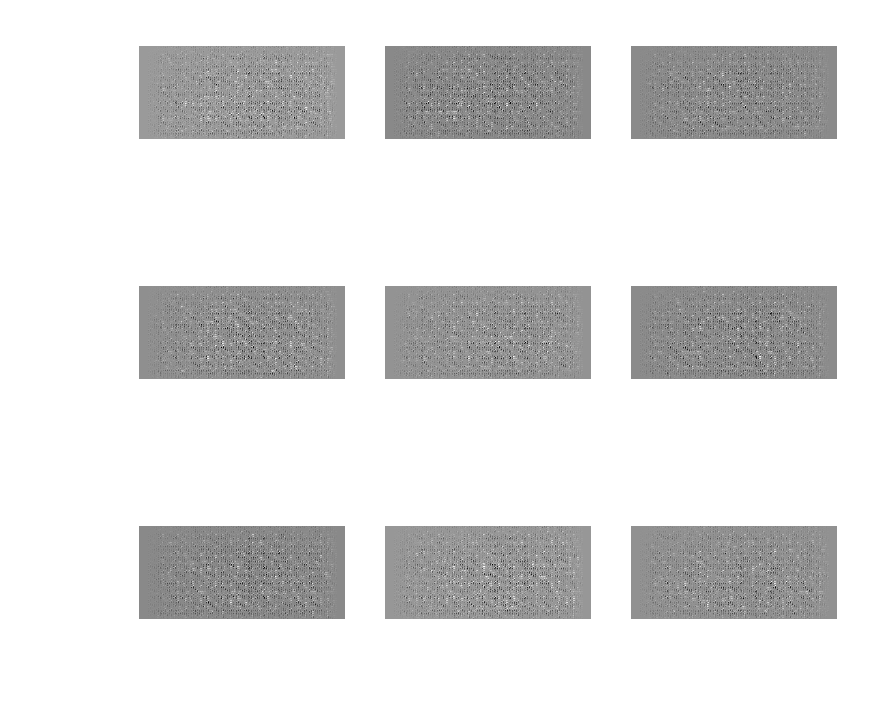

          E_gen :  0.54535556  E_real :  0.8316278 W_loss :  -0.28627223  GradNormPenalty :  0.31136072
     disc_loss :  0.025088489
          E_gen :  0.40413606  E_real :  0.7159449 W_loss :  -0.31180882  GradNormPenalty :  0.2323135
     disc_loss :  -0.079495326
          E_gen :  0.67671686  E_real :  0.95819014 W_loss :  -0.28147328  GradNormPenalty :  0.41981903
     disc_loss :  0.13834575
          E_gen :  0.3520197  E_real :  0.7614983 W_loss :  -0.40947857  GradNormPenalty :  0.26671818
     disc_loss :  -0.1427604
          E_gen :  0.5107815  E_real :  0.8618069 W_loss :  -0.3510254  GradNormPenalty :  0.25238138
     disc_loss :  -0.09864402
gen_loss :  -0.0022299765  Time taken for epoch 2 is 301.7329156398773 sec


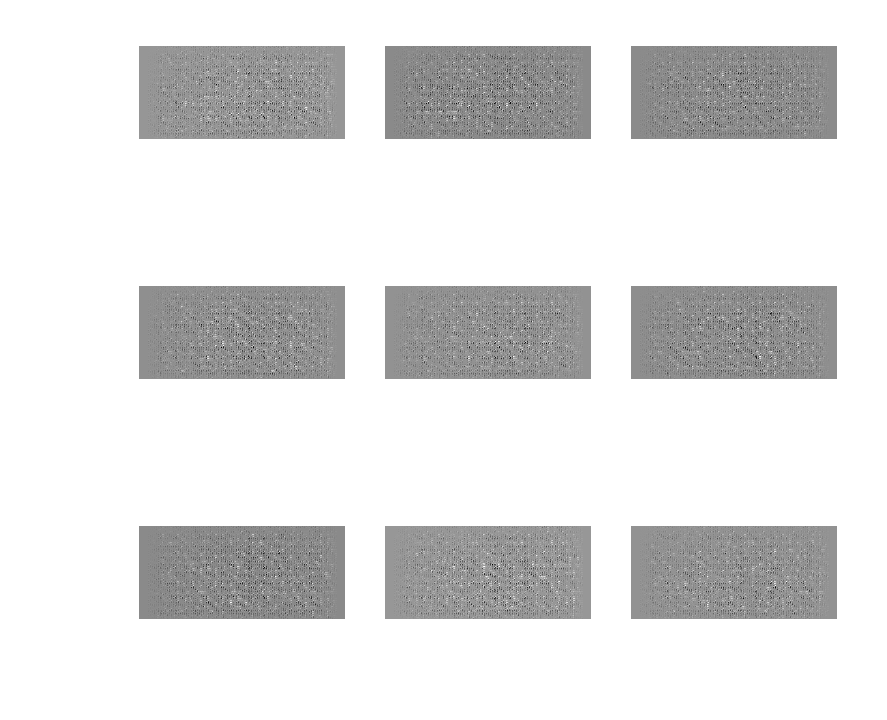

          E_gen :  0.38251343  E_real :  0.7078465 W_loss :  -0.3253331  GradNormPenalty :  0.23040551
     disc_loss :  -0.09492758
          E_gen :  0.5475983  E_real :  0.87317663 W_loss :  -0.32557833  GradNormPenalty :  0.20372525
     disc_loss :  -0.12185308
          E_gen :  0.37723666  E_real :  0.7429194 W_loss :  -0.36568272  GradNormPenalty :  0.1717541
     disc_loss :  -0.19392861
          E_gen :  0.54669565  E_real :  0.9383126 W_loss :  -0.39161694  GradNormPenalty :  0.201468
     disc_loss :  -0.19014893
          E_gen :  0.3777057  E_real :  0.76023215 W_loss :  -0.38252646  GradNormPenalty :  0.1754444
     disc_loss :  -0.20708206
gen_loss :  -0.14928328  Time taken for epoch 3 is 301.69956040382385 sec


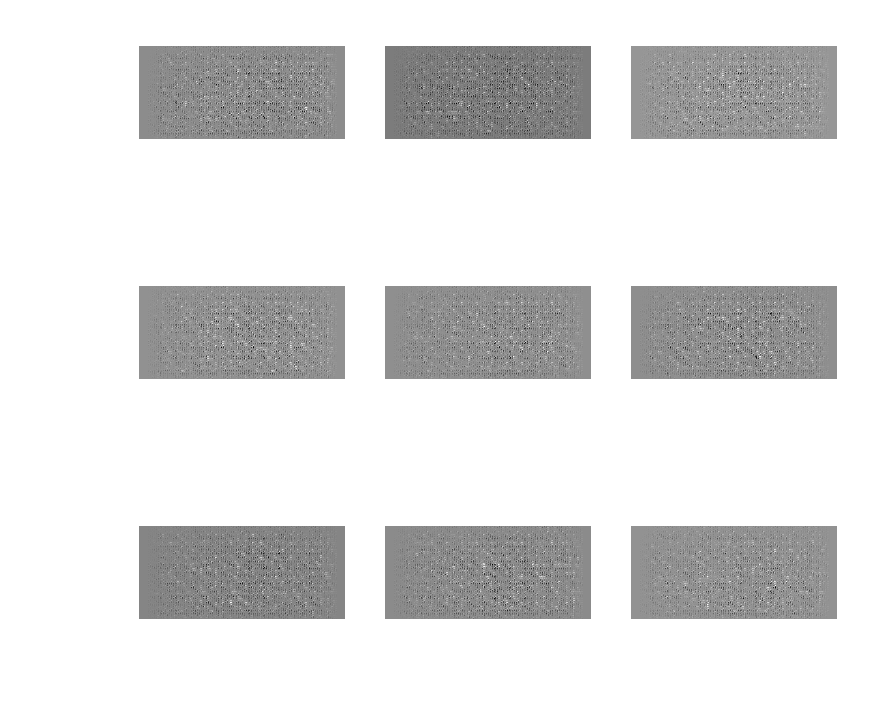

          E_gen :  0.5249842  E_real :  0.91320753 W_loss :  -0.38822335  GradNormPenalty :  0.12394639
     disc_loss :  -0.26427695
          E_gen :  0.31557953  E_real :  0.69970584 W_loss :  -0.3841263  GradNormPenalty :  0.1310465
     disc_loss :  -0.2530798
          E_gen :  0.69952095  E_real :  0.9811459 W_loss :  -0.28162497  GradNormPenalty :  0.33048278
     disc_loss :  0.048857808
          E_gen :  0.4316064  E_real :  0.8887307 W_loss :  -0.4571243  GradNormPenalty :  0.13147129
     disc_loss :  -0.32565302
          E_gen :  0.32691333  E_real :  0.7098429 W_loss :  -0.3829296  GradNormPenalty :  0.14601006
     disc_loss :  -0.23691954
gen_loss :  -0.7014666  Time taken for epoch 4 is 298.18424892425537 sec


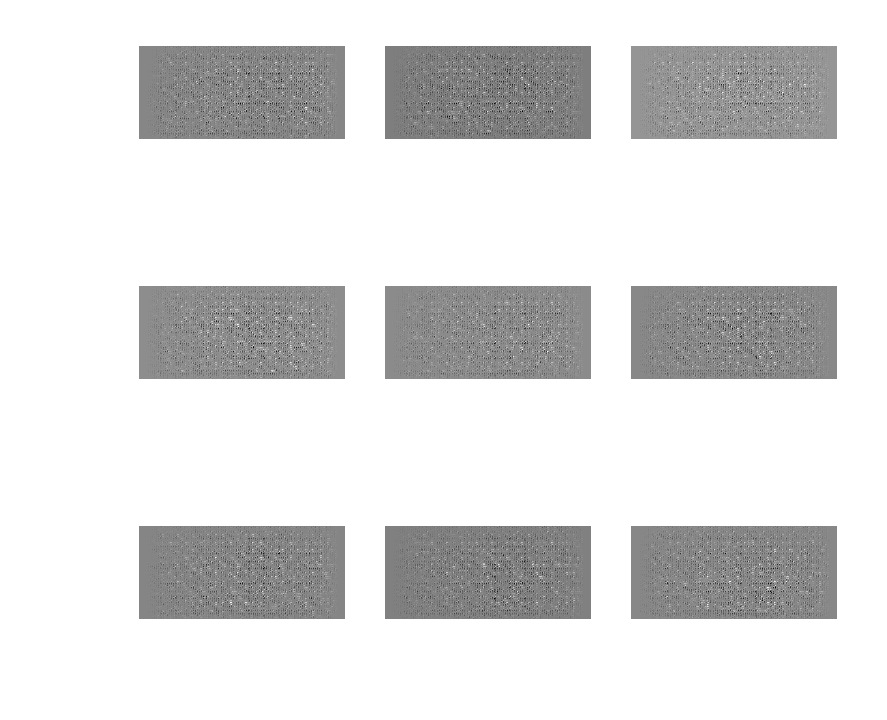

          E_gen :  0.58176935  E_real :  0.9056724 W_loss :  -0.32390302  GradNormPenalty :  0.074912764
     disc_loss :  -0.24899027
          E_gen :  0.4685828  E_real :  0.8609338 W_loss :  -0.39235097  GradNormPenalty :  0.057556182
     disc_loss :  -0.3347948
          E_gen :  0.36863858  E_real :  0.7929404 W_loss :  -0.4243018  GradNormPenalty :  0.08906685
     disc_loss :  -0.33523494
          E_gen :  0.40092948  E_real :  0.9502212 W_loss :  -0.54929173  GradNormPenalty :  0.17563501
     disc_loss :  -0.37365672
          E_gen :  0.46679288  E_real :  0.91963804 W_loss :  -0.45284516  GradNormPenalty :  0.13766193
     disc_loss :  -0.31518322
gen_loss :  -0.25926006  Time taken for epoch 5 is 298.9635081291199 sec


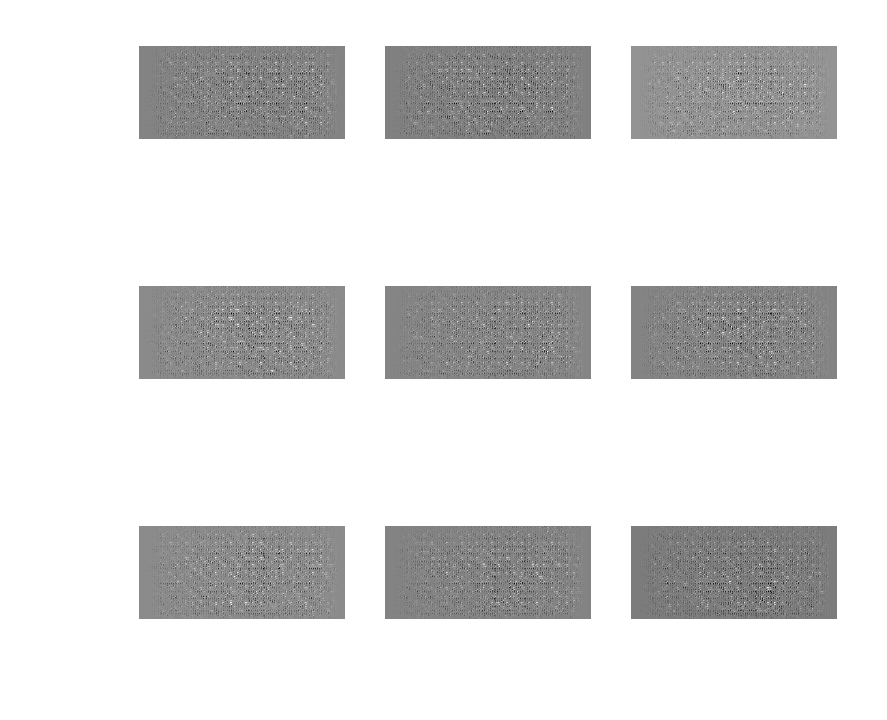

          E_gen :  0.29278082  E_real :  0.5375961 W_loss :  -0.24481529  GradNormPenalty :  0.054995526
     disc_loss :  -0.18981977
          E_gen :  0.5124675  E_real :  0.948216 W_loss :  -0.43574852  GradNormPenalty :  0.06366828
     disc_loss :  -0.37208024
          E_gen :  0.4935957  E_real :  0.96437377 W_loss :  -0.47077808  GradNormPenalty :  0.108686484
     disc_loss :  -0.3620916
          E_gen :  0.32420474  E_real :  0.81532174 W_loss :  -0.491117  GradNormPenalty :  0.21448578
     disc_loss :  -0.27663124
          E_gen :  0.3876394  E_real :  0.895007 W_loss :  -0.5073676  GradNormPenalty :  0.11767
     disc_loss :  -0.3896976
gen_loss :  -0.781333  Time taken for epoch 6 is 300.31101536750793 sec


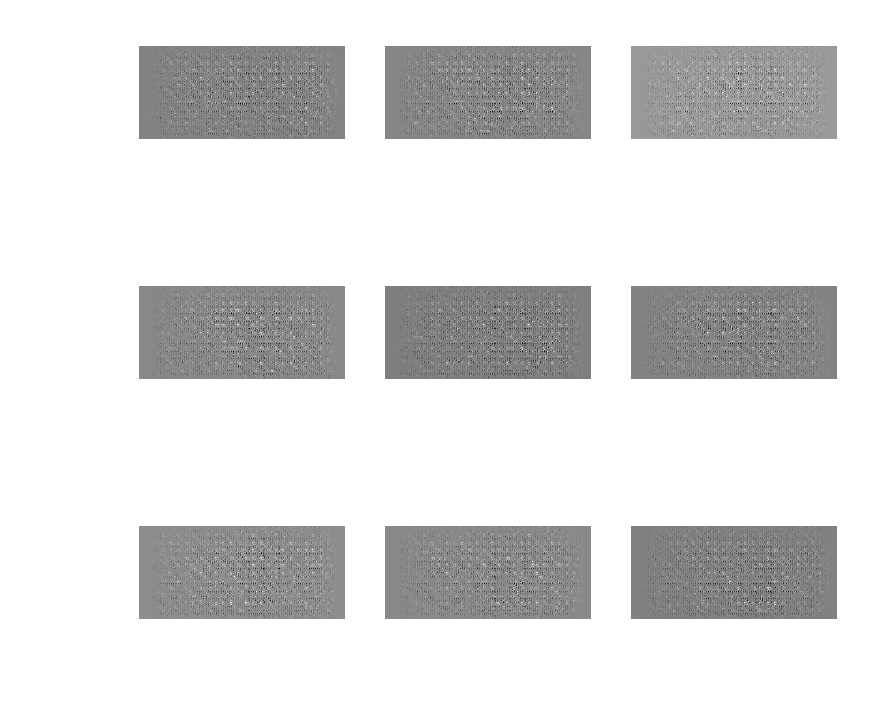

In [0]:

%matplotlib inline

import matplotlib as mpl
#https://matplotlib.org/users/customizing.html
#mpl.rcParams['figure.figsize'] = (10,10)
plt.rcParams['figure.dpi'] = 300


# Reference: https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb


tf.enable_eager_execution()

EPOCHS = 500
BATCH_SIZE=50

noise_dim = 3*6*512
num_examples_to_generate = 9

learning_rate = 0.0001
beta1 = 0.5 # first momentum decay 
beta2 = 0.9
epsilon = 1e-4
ncritic = 5
lambd = 10

checkpoint_dir = 'training_checkpoints/'

def gen_tensor(batch_size):
    list = []
    for i in range(batch_size):
        img = RCgen()
        list.append(img)
    imgs = tf.stack(list, axis=0)
    return imgs

def generator(batch_size):
    yield gen_tensor(batch_size)

train_dataset = tf.data.Dataset.from_generator(generator, (tf.float32), args = ([BATCH_SIZE]))
iterator = train_dataset.make_one_shot_iterator()

noise = tf.random_normal([BATCH_SIZE, noise_dim]) 

random_vector_for_generation = tf.random_normal([num_examples_to_generate,noise_dim])

# For validating the training dataset
#for images in train_dataset:
#   print(images.shape)
#    for i in range(BATCH_SIZE):
#        plt.imshow(tf.gather(images,i))
#        plt.show()


generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2=beta2, epsilon=epsilon)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1,beta2=beta2, epsilon=epsilon)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

train(train_dataset, EPOCHS, ncritic, lambd)